## In the following cell, please change the various path to the ones corresponding to your system

In [1]:
#### CHANGE THE PATH TO CORRESPOND TO THE PATH ON YOUR SYSTEM
### The path that should be changed are preceded with <--- CHANGE --->

def initialize(movie):
    # Generate folders for organized storage
    folders = ["fmri_mean_{}", "wards_{}", "fmri_ready_{}", "results"]
    for folder in folders :
        folder_name = folder.format(movie)
        try :
            os.mkdir(folder_name)
        except OSError :
            print("Folder already exists, skipping creation ({})".format(folder_name))
        else :
            print("Folder created  ({})".format(folder_name))

    result_folders = ["results/{}_conv{}".format(movie, id_layer) for id_layer in range(1,8)]
    for result_folder in result_folders :
        try :
            os.mkdir(result_folder)
        except OSError :
            print("Folder already exists, skipping creation ({})".format(result_folder))
        else :
            print("Folder created ({})".format(result_folder))
    
    # Set the differents path to data and folders

    # path to dataset of Sherlock or Merlin or TwilightZone
    if movie in ("sherlock","merlin"):
        # fmri data location
        
        # Location of the dataset
        # <--- CHANGE --->
        local_movie_path = "/home/brain/datasets/SherlockMerlin_ds001110/"
        
        # mask name
        movie_mask =  "{}Movie_bold_space-T1w_brainmask.nii.gz".format(movie.capitalize())
        
        # Generic name of the brain masks (non MNI) from the dataset
        # <--- CHANGE --->
        generic_mask_name = "/home/brain/datasets/SherlockMerlin_ds001110/sub-{:02d}/func/sub-{:02d}_task-" + movie_mask
        
        # fmri file name
        generic_filename = "sub-{:02d}_task-" + "{}Movie_bold_space-T1w_preproc.nii.gz".format(movie.capitalize())
        
        # anat file name
        
        # <--- CHANGE --->
        anat_filename = "/home/brain/victor/datasets/fmri_anat_{}/".format(movie) + "sub-{:02d}.nii.gz"
        
    elif movie == "twilight-zone" :
        # fmri data location
        # <--- CHANGE --->
        local_movie_path = "/home/brain/victor/datasets/twilight-zone"
        
        # there are no pre-existing masks
        generic_mask_name = ""
        
        # fmri file name
        generic_filename = "sub-{:02d}_task-watchmovie_bold.nii.gz"
    else :
        raise ValueError("The movie name has to be 'twilight-zone', 'merlin' or 'sherlock'")

        
    # locate the folder containing feature vectors extracted from soundnet for the corresponding movie (merlin_pytorch or sherlock_pytorch
    # <--- CHANGE --->
    feature_folder = "soundnet_features/{}_pytorch/".format(movie)

    # folder for storing the resulting r2 brain maps
    folder_name = "results/{}_".format(movie)
    result_folder = folder_name + "conv{}/"
    
    # Configure the subjects corresponding to the movie : 
    # Sherlock : [1,18]\{5} 
    # Merlin : [19,37]\{25}
    # Twilight-zone : [1,25]
    id_subjects = {
    "sherlock": (1,18,5),
    "merlin": (19,37,25),
    "twilight-zone": (1,25,0)
    }

    sub_values = id_subjects[movie]
    
    return local_movie_path, generic_mask_name, generic_filename, anat_filename, feature_folder, result_folder, sub_values


In [2]:
# nilearn imports
from nilearn.plotting import plot_roi, plot_stat_map, plot_anat, view_img, cm
from nilearn.image import mean_img

/home/brain/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
### Remove useless warnings from scikit learn

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [4]:
# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

In [28]:
# sklearn imports
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [6]:
# utility imports
import numpy as np
from matplotlib import pyplot as plt
import os.path
from joblib import dump, load
import tqdm

In [7]:
class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, labels, fv_vector):
        'Initialization'
        self.labels = labels
        self.vectors = fv_vector

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.vectors)


  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        # Load data and get label
        X = self.vectors[index]
        y = self.labels[index]

        return X, y


In [8]:
from nilearn.regions import Parcellations
from nilearn.input_data import NiftiMasker
from nilearn.masking import compute_background_mask
import os

def parcellate(id_subject, n_frames, compute_mean = True, compute_ward = True, compute_ready = True):
    # Compute the ward parcellation and other fmri data of a given subject and save it
    
    folder_name = "sub-{:02d}/func".format(id_subject)
    subject_filename = generic_filename.format(id_subject)
    fmri_file = os.path.join(local_movie_path,folder_name, subject_filename)

    # Compute the mean of fmri accross time
    if  compute_mean or not os.path.isfile("fmri_mean_{}/sub-{:02d}.nii.gz".format(movie, id_subject)):
        fmri_mean = mean_img(fmri_file)
        fmri_mean.to_filename("fmri_mean_{}/sub-{:02d}.nii.gz".format(movie, id_subject))
        print("Saved mean fmri for subject {}".format(id_subject))
    else :
        print("Mean fmri already exists for subject {}".format(id_subject))
        fmri_mean = "fmri_mean_{}/sub-{:02d}.nii.gz".format(movie, id_subject)
 
    # Compute mask if the movie is twilight-zone 
    if movie == "twilight-zone":
        print("Computing background mask")
        mask_img = compute_background_mask(fmri_file)
    else :
        print("Loading pre-generated mask")
        mask_img = generic_mask_name.format(id_subject,id_subject)
    
    # Compute ward parcellation
    if compute_ward or not os.path.isfile("wards_{}/sub-{:02d}.nii.gz".format(movie,id_subject)):
        masker = NiftiMasker(mask_img=mask_img, detrend=True,standardize=True)
        masker.fit()
        ward = Parcellations(method='ward',mask=masker,standardize=True,smoothing_fwhm=None,n_parcels=500)
        ward.fit(fmri_file)
        dump(ward, "wards_{}/sub-{:02d}.nii.gz".format(movie,id_subject))
        print("Saved ward mask for subject {}".format(id_subject))
    else :
        ward = load("wards_{}/sub-{:02d}.nii.gz".format(movie,id_subject))
        print("Ward mask exists for subject {}".format(id_subject))

     # Compute fmri_ready       
    if compute_ready or not os.path.isfile("fmri_ready_{}/sub-{:02d}.npy".format(movie, id_subject)):
        print("fmri_file : ", fmri_file)
        fmri_data = ward.transform(fmri_file)
        # Truncate the data because of an offset in the fmri (see dataset description)
        if movie in ("merlin, sherlock"):
            # 25 seconds of offset, and 1.5s per frame
            fmri_ready = fmri_data[17:-(fmri_data.shape[0]-17-n_frames)]
        else :
            # 15 TR of offset, and 1.5s per frame
            fmri_ready = fmri_data[15:-(fmri_data.shape[0]-15-n_frames)]
        np.save("fmri_ready_{}/sub-{:02d}".format(movie, id_subject), fmri_ready)    
        print("Saved fmri_ready for subject {}".format(id_subject))
    else :
        print("fmri_ready exists for subject {} and movie {}".format(id_subject, movie))

In [9]:
def load_feature_vector(id_layer) :
    filename = "conv{}.npz".format(id_layer)
    file_fv = os.path.join(feature_folder, filename)
    fv = np.load(file_fv)['fv'][1:]
    # Check the size
    n_frames = fv.shape[0]
    fv_normalized = StandardScaler().fit_transform(fv)
    print("layer {}, {} frames, FV dimension is {}".format(id_layer,n_frames, fv.shape[1]))
    return fv_normalized, n_frames

In [10]:
def load_fmri_data(id_subject):
    fmri_ready_path = "fmri_ready_{}/sub-{:02d}.npy".format(movie, id_subject)
    fmri_ready = np.load(fmri_ready_path)[1:]
    print("Loaded {}, with length : {}".format(fmri_ready_path, len(fmri_ready)))
    
    fmri_mean_path = "fmri_mean_{}/sub-{:02d}.nii.gz".format(movie, id_subject)
    print("Loaded {}".format(fmri_mean_path))
    
    ward_path = "wards_{}/sub-{:02d}.nii.gz".format(movie, id_subject)
    ward = load(ward_path)
    print("Loaded {}".format(ward_path))
    
    return fmri_ready, fmri_mean_path, ward

In [11]:
def load_data(id_layer,id_subject): 
    X, _ = load_feature_vector(id_layer)
    X_tensor = torch.tensor(X, dtype = torch.float, requires_grad = True)
    y, fmri_mean, ward = load_fmri_data(id_subject)
    y_tensor = torch.tensor(y, dtype = torch.float, requires_grad = True)
    return X, y, fmri_mean, ward

In [12]:
# Movie has to be 'sherlock', 'merlin' or 'twilight-zone'
movie = 'sherlock'
device = torch.device("cuda:0")
local_movie_path, generic_mask_name, generic_filename, anat_filename, feature_folder, result_folder, sub_values = initialize(movie)
min_sub, max_sub, null_sub = sub_values

Folder already exists, skipping creation (fmri_mean_sherlock)
Folder already exists, skipping creation (wards_sherlock)
Folder already exists, skipping creation (fmri_ready_sherlock)
Folder already exists, skipping creation (results)
Folder already exists, skipping creation (results/sherlock_conv1)
Folder already exists, skipping creation (results/sherlock_conv2)
Folder already exists, skipping creation (results/sherlock_conv3)
Folder already exists, skipping creation (results/sherlock_conv4)
Folder already exists, skipping creation (results/sherlock_conv5)
Folder already exists, skipping creation (results/sherlock_conv6)
Folder already exists, skipping creation (results/sherlock_conv7)


In [13]:
print(os.getcwd())
_, n_frames = load_feature_vector(7)
for id_subject in range(min_sub, max_sub):
    if id_subject != null_sub :
        parcellate(id_subject, n_frames)

/home/brain/victor/stage/git_repository
layer 7, 945 frames, FV dimension is 1024


ValueError: File not found: '/home/brain/datasets/SherlockMerlin_ds001110/sub-01/func/sub-01_task-SherlockMovie_bold_space-T1w_preproc.nii.gz'

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(1024, 1000)  
        self.fc2 = nn.Linear(1000, 500)

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.cpu()
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [15]:
import matplotlib.pyplot as plt
import numpy as np

In [69]:
        predictions = []
        for train, target in zip(X_test,y_test) :
            train = torch.tensor(train)
            output = net(train)
            predictions.append(output.detach().numpy())
        predictions = np.array(predictions)
        y_test = np.array(y_test)
        scores_mlp = r2_score(y_test, predictions, multioutput='raw_values')
        scores_mlp[scores_mlp < 0] = 0
        scores_img = ward.inverse_transform(scores_mlp.reshape((1,-1)))
        views.append(scores_img)
    return views

IndentationError: unexpected indent (<ipython-input-69-4a019a46980a>, line 12)

In [81]:
def train(id_subject) :
    X,y,fmri_mean, ward = load_data(id_layer = 7, id_subject = id_subject)
    fold_number = 1
    views = []

    for train_index, test_index in cv.split(X):
        ### Create a NEW neural network
        net = Net()
        net.to(device)
        # Generate data
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1)
        train_length = X_train.shape[0]
        validation_length = X_val.shape[0]
        testing_length = X_test.shape[0]
        training_set = Dataset(y_train, X_train)
        validation_set = Dataset(y_val, X_val)
        testing_set = Dataset(y_test, X_test)
        training_generator = data.DataLoader(training_set, **params)
        validation_generator = data.DataLoader(validation_set, **params)
        testing_generator = data.DataLoader(testing_set, **params)
        # Create optimizer
        optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay = 0.0001)
        criterion = nn.MSELoss()
        
        # Prepare logging
        train_losses = []
        validation_losses = []
        validation_loss_previous = 1e10
        for epoch in range(max_epochs) :
            minibatch_number = 1
            loss_sum = 0
            for local_batch, local_labels in training_generator:
                optimizer.zero_grad()   # zero the gradient buffers
                output = net(local_batch)
                loss = criterion(output, local_labels.float())
                loss.backward()
                optimizer.step() # Does the update
                loss_sum += loss.item()
                minibatch_number += 1
            train_loss = loss_sum / train_length
            train_losses.append(train_loss)
            print("train loss epoch {} fold {}: {}".format(epoch, fold_number, train_loss))
            
            minibatch_number = 1
            loss_sum = 0
            with torch.set_grad_enabled(False):
                for local_batch, local_labels in validation_generator:
                    output = net(local_batch)
                    loss = criterion(output, local_labels.float())
                    loss_sum += loss.item()
                    minibatch_number += 1
            validation_loss = loss_sum / validation_length
            validation_losses.append(validation_loss)
            print("validation loss epoch {} fold {}: {}".format(epoch, fold_number, validation_loss))
            if validation_loss > 1.001*validation_loss_previous and epoch > 20 :
                print("Early stopping !")
                break
            validation_loss_previous = validation_loss

        minibatch_number = 1
        loss_sum = 0
        with torch.set_grad_enabled(False):
            for local_batch, local_labels in testing_generator:
                output = net(local_batch)
                loss = criterion(output, local_labels.float())
                loss_sum += loss.item()
                minibatch_number += 1
            test_loss = loss_sum / testing_length
        print("Testing loss : {}".format(test_loss))
        plt.plot([i for i in range(len(train_losses))], train_losses,)
        plt.plot([i for i in range(len(validation_losses))], validation_losses,)
        plt.legend(["train loss" ,"validation loss"])
        plt.show()
        
        fold_number += 1
                    

layer 7, 945 frames, FV dimension is 1024
Loaded fmri_ready_sherlock/sub-15.npy, with length : 945
Loaded fmri_mean_sherlock/sub-15.nii.gz
Loaded wards_sherlock/sub-15.nii.gz
train loss epoch 0 fold 1: 0.01761822704243323
validation loss epoch 0 fold 1: 0.02271155404372954
train loss epoch 1 fold 1: 0.01652063988441575
validation loss epoch 1 fold 1: 0.021767858048559914
train loss epoch 2 fold 1: 0.015969418094521227
validation loss epoch 2 fold 1: 0.021323716136771188
train loss epoch 3 fold 1: 0.01564213638215836
validation loss epoch 3 fold 1: 0.021203402902039006
train loss epoch 4 fold 1: 0.015419128551213671
validation loss epoch 4 fold 1: 0.021242856979370117
train loss epoch 5 fold 1: 0.015235858397730853
validation loss epoch 5 fold 1: 0.02127476477287185
train loss epoch 6 fold 1: 0.015070008613999635
validation loss epoch 6 fold 1: 0.021326278296994492
train loss epoch 7 fold 1: 0.014917070206892173
validation loss epoch 7 fold 1: 0.021390842719816824
train loss epoch 8 fol

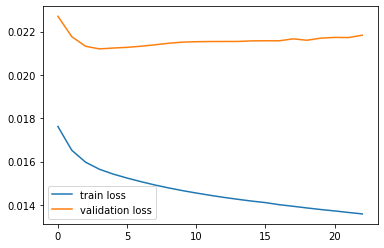

train loss epoch 0 fold 2: 0.020576935483370456
validation loss epoch 0 fold 2: 0.027360427547508562
train loss epoch 1 fold 2: 0.018899590711234877
validation loss epoch 1 fold 2: 0.025905306070623264
train loss epoch 2 fold 2: 0.018176223323636668
validation loss epoch 2 fold 2: 0.02541930742666755
train loss epoch 3 fold 2: 0.017907896946216452
validation loss epoch 3 fold 2: 0.025237984220746537
train loss epoch 4 fold 2: 0.017679890681957376
validation loss epoch 4 fold 2: 0.02507185012521878
train loss epoch 5 fold 2: 0.01748900475173161
validation loss epoch 5 fold 2: 0.024982572441369717
train loss epoch 6 fold 2: 0.017332177924511947
validation loss epoch 6 fold 2: 0.024943033574332654
train loss epoch 7 fold 2: 0.01718432720178347
validation loss epoch 7 fold 2: 0.024908942236027246
train loss epoch 8 fold 2: 0.01705317932610228
validation loss epoch 8 fold 2: 0.024908445250820106
train loss epoch 9 fold 2: 0.016930703552539072
validation loss epoch 9 fold 2: 0.02492448813478

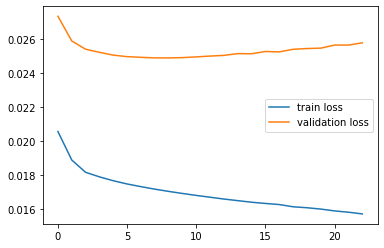

train loss epoch 0 fold 3: 0.020190877507099164
validation loss epoch 0 fold 3: 0.02618523718605579
train loss epoch 1 fold 3: 0.018506035161989984
validation loss epoch 1 fold 3: 0.024807582438831598
train loss epoch 2 fold 3: 0.017694747186379745
validation loss epoch 2 fold 3: 0.024733449371767715
train loss epoch 3 fold 3: 0.017306430306180516
validation loss epoch 3 fold 3: 0.023888247953334326
train loss epoch 4 fold 3: 0.01698576563204344
validation loss epoch 4 fold 3: 0.023508047553854928
train loss epoch 5 fold 3: 0.01673753283987972
validation loss epoch 5 fold 3: 0.02324814108056082
train loss epoch 6 fold 3: 0.016540660286398143
validation loss epoch 6 fold 3: 0.02306232150171844
train loss epoch 7 fold 3: 0.01637630365485308
validation loss epoch 7 fold 3: 0.02295093553166994
train loss epoch 8 fold 3: 0.0162376192483035
validation loss epoch 8 fold 3: 0.02282380050336811
train loss epoch 9 fold 3: 0.01611424314564672
validation loss epoch 9 fold 3: 0.022785128841937428
t

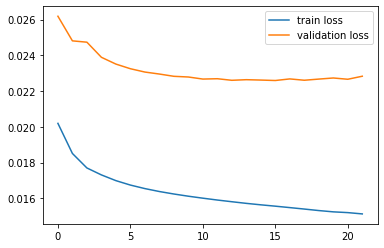

train loss epoch 0 fold 4: 0.017890809751976995
validation loss epoch 0 fold 4: 0.023422115285631637
train loss epoch 1 fold 4: 0.01620460191864205
validation loss epoch 1 fold 4: 0.022305873078359684
train loss epoch 2 fold 4: 0.015635650920270003
validation loss epoch 2 fold 4: 0.022014762314272598
train loss epoch 3 fold 4: 0.015390950030293959
validation loss epoch 3 fold 4: 0.021956100430287107
train loss epoch 4 fold 4: 0.015229515334281803
validation loss epoch 4 fold 4: 0.021966750353155002
train loss epoch 5 fold 4: 0.01509068359775603
validation loss epoch 5 fold 4: 0.02194332908576643
train loss epoch 6 fold 4: 0.014951741620664686
validation loss epoch 6 fold 4: 0.021918285900438334
train loss epoch 7 fold 4: 0.014814744455313607
validation loss epoch 7 fold 4: 0.021895413667383328
train loss epoch 8 fold 4: 0.014679960696301116
validation loss epoch 8 fold 4: 0.0218746628559811
train loss epoch 9 fold 4: 0.014549369909172894
validation loss epoch 9 fold 4: 0.02187185388215

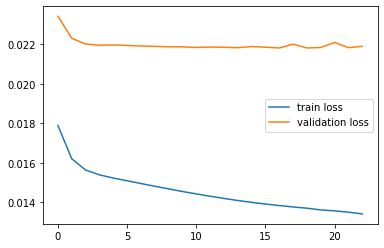

In [82]:
### TRAIN THE NETWORK
import torch.optim as optim
n_folds = 4
cv = KFold(n_splits = n_folds)


# Add labels
max_epochs = 1000
params = { 
    'batch_size': 50,
    'shuffle': False,
    'num_workers': 6
}
id_subject = 15
images = train(id_subject)

In [28]:
fmri_anat = "fmri_anat/sub-{:02d}.nii.gz".format(id_subject)
view = view_img(images[0], bg_img = fmri_anat, cmap = cm.black_blue, dim = -0.5, symmetric_cmap = False, threshold = 0.10)
view